In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from collections import deque

# Automatically use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not detected. Using CPU instead.")

print("Active device:", device)

Using device: cpu


In [ ]:
# === CartPole Environment Setup ===
env = gym.make('CartPole-v1', render_mode=None)
print("Observation space:", env.observation_space.shape)
print("Action space:", env.action_space)


Observation space: (4,)
Action space: Discrete(2)


In [ ]:
# === Policy Network for CartPole ===
class PolicyNetCartPole(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.model(x)


In [14]:
# === Function to Compute Discounted Returns ===
def compute_returns(rewards, gamma):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns


In [15]:
# === Train Policy Gradient for CartPole-v1 ===
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy = PolicyNetCartPole(state_dim, action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.01)
gamma = 0.95

num_episodes = 2000
episode_rewards = []
moving_avg = deque(maxlen=100)

for episode in range(num_episodes):
    state, _ = env.reset()
    log_probs = []
    rewards = []
    done = False
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = policy(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        
        next_state, reward, done, truncated, info = env.step(action.item())
        log_probs.append(dist.log_prob(action))
        rewards.append(reward)
        state = next_state
    
    returns = compute_returns(rewards, gamma)
    loss = -torch.sum(torch.stack(log_probs) * returns.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_reward = sum(rewards)
    episode_rewards.append(total_reward)
    moving_avg.append(total_reward)
    
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode+1}, Reward: {total_reward:.2f}, 100-ep Avg: {np.mean(moving_avg):.2f}")

env.close()


Episode 50, Reward: 30.00, 100-ep Avg: 16.76
Episode 100, Reward: 10.00, 100-ep Avg: 17.06
Episode 150, Reward: 15.00, 100-ep Avg: 14.03
Episode 200, Reward: 14.00, 100-ep Avg: 11.70
Episode 250, Reward: 12.00, 100-ep Avg: 13.27
Episode 300, Reward: 19.00, 100-ep Avg: 14.74
Episode 350, Reward: 9.00, 100-ep Avg: 14.28
Episode 400, Reward: 11.00, 100-ep Avg: 12.45
Episode 450, Reward: 9.00, 100-ep Avg: 11.09
Episode 500, Reward: 10.00, 100-ep Avg: 9.68
Episode 550, Reward: 9.00, 100-ep Avg: 9.28
Episode 600, Reward: 9.00, 100-ep Avg: 9.49
Episode 650, Reward: 9.00, 100-ep Avg: 9.50
Episode 700, Reward: 9.00, 100-ep Avg: 9.40
Episode 750, Reward: 9.00, 100-ep Avg: 9.32
Episode 800, Reward: 10.00, 100-ep Avg: 9.33
Episode 850, Reward: 9.00, 100-ep Avg: 9.32
Episode 900, Reward: 8.00, 100-ep Avg: 9.32
Episode 950, Reward: 8.00, 100-ep Avg: 9.33
Episode 1000, Reward: 9.00, 100-ep Avg: 9.39
Episode 1050, Reward: 9.00, 100-ep Avg: 9.53
Episode 1100, Reward: 10.00, 100-ep Avg: 9.42
Episode 115

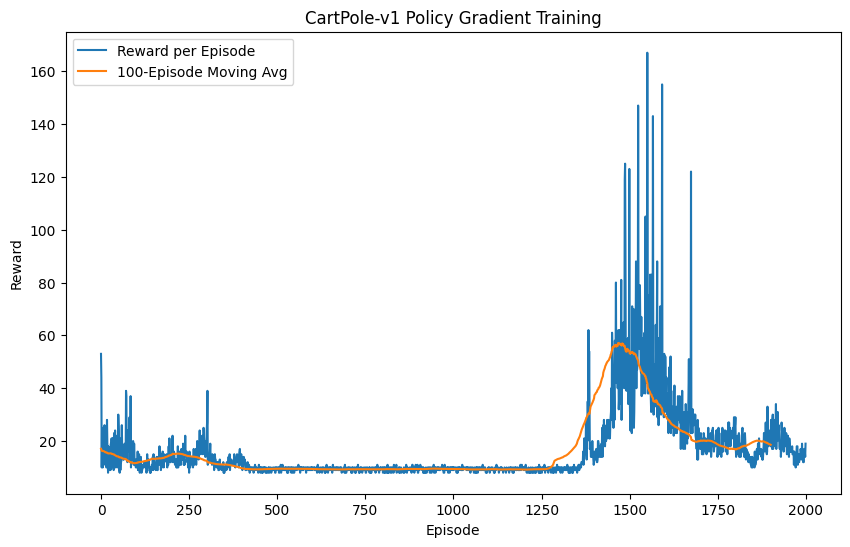

In [16]:
# === Plot Episode Rewards and Moving Average ===
plt.figure(figsize=(10,6))
plt.plot(episode_rewards, label='Reward per Episode')
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'), label='100-Episode Moving Avg')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('CartPole-v1 Policy Gradient Training')
plt.legend()
plt.show()


Mean Return = 15.07, Std = 2.43


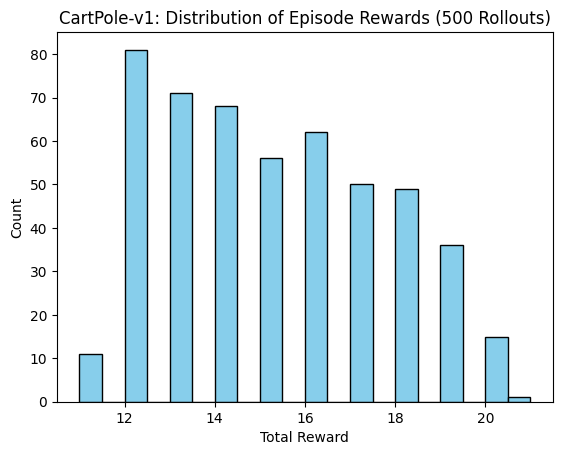

In [17]:
# === Evaluate Trained Policy over 500 Episodes ===
def evaluate_policy(env, policy, episodes=500):
    rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                probs = policy(state)
            action = torch.argmax(probs, dim=1).item()
            state, reward, done, truncated, info = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

eval_env = gym.make('CartPole-v1')
eval_returns = evaluate_policy(eval_env, policy)
print(f"Mean Return = {eval_returns.mean():.2f}, Std = {eval_returns.std():.2f}")

plt.hist(eval_returns, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Count')
plt.title('CartPole-v1: Distribution of Episode Rewards (500 Rollouts)')
plt.show()


In [18]:
# === Preprocess Function for Pong (Provided in PDF and Reference File) ===
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195]  # crop
    image = image[::2, ::2, 0]  # downsample by factor of 2
    image[image == 144] = 0  # erase background (type 1)
    image[image == 109] = 0  # erase background (type 2)
    image[image != 0] = 1  # paddles and ball to 1
    return np.reshape(image.astype(np.float32).ravel(), [80, 80])


In [19]:
# === Policy Network for Pong (Simple Neural Net) ===
class PolicyNetPong(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(80*80, 200),
            nn.ReLU(),
            nn.Linear(200, 2),  # only LEFT (2) and RIGHT (3)
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.model(x)


In [ ]:
# === Train Policy Gradient for Pong-v5 ===
import ale_py
gym.register_envs(ale_py)

env = gym.make('ALE/Pong-v5', render_mode=None)
policy_pong = PolicyNetPong().to(device)
optimizer = optim.Adam(policy_pong.parameters(), lr=0.01)
gamma = 0.99

num_episodes = 1000
episode_rewards = []
moving_avg = deque(maxlen=100)

for episode in range(num_episodes):
    obs, _ = env.reset()
    prev_x = None
    log_probs, rewards = [], []
    done = False
    
    while not done:
        cur_x = preprocess(obs)
        x = cur_x - prev_x if prev_x is not None else np.zeros_like(cur_x)
        prev_x = cur_x
        
        state = torch.from_numpy(x.ravel()).float().to(device)
        probs = policy_pong(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        
        mapped_action = 2 if action.item() == 0 else 3  # map [0,1] - [RIGHT, LEFT]
        obs, reward, done, truncated, info = env.step(mapped_action)
        
        log_probs.append(dist.log_prob(action))
        rewards.append(reward)
    
    returns = compute_returns(rewards, gamma)
    loss = -torch.sum(torch.stack(log_probs) * returns.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_reward = sum(rewards)
    episode_rewards.append(total_reward)
    moving_avg.append(total_reward)
    
    if (episode + 1) % 20 == 0:
        print(f"Episode {episode+1}, Reward: {total_reward:.2f}, 100-ep Avg: {np.mean(moving_avg):.2f}")

env.close()


Episode 20, Reward: -20.00, 100-ep Avg: -20.20
Episode 40, Reward: -20.00, 100-ep Avg: -20.20
Episode 60, Reward: -18.00, 100-ep Avg: -19.93
Episode 80, Reward: -17.00, 100-ep Avg: -19.71
Episode 100, Reward: -15.00, 100-ep Avg: -19.71
Episode 120, Reward: -18.00, 100-ep Avg: -19.36
Episode 140, Reward: -18.00, 100-ep Avg: -18.88
Episode 160, Reward: -21.00, 100-ep Avg: -18.71
Episode 180, Reward: -20.00, 100-ep Avg: -18.80
Episode 200, Reward: -21.00, 100-ep Avg: -18.98
Episode 220, Reward: -21.00, 100-ep Avg: -19.45
Episode 240, Reward: -19.00, 100-ep Avg: -19.91
Episode 260, Reward: -20.00, 100-ep Avg: -19.99
Episode 280, Reward: -21.00, 100-ep Avg: -20.07
Episode 300, Reward: -16.00, 100-ep Avg: -19.66
Episode 320, Reward: -18.00, 100-ep Avg: -19.09
Episode 340, Reward: -20.00, 100-ep Avg: -19.05
Episode 360, Reward: -20.00, 100-ep Avg: -19.31
Episode 380, Reward: -16.00, 100-ep Avg: -19.24
Episode 400, Reward: -20.00, 100-ep Avg: -19.19
Episode 420, Reward: -17.00, 100-ep Avg: -19

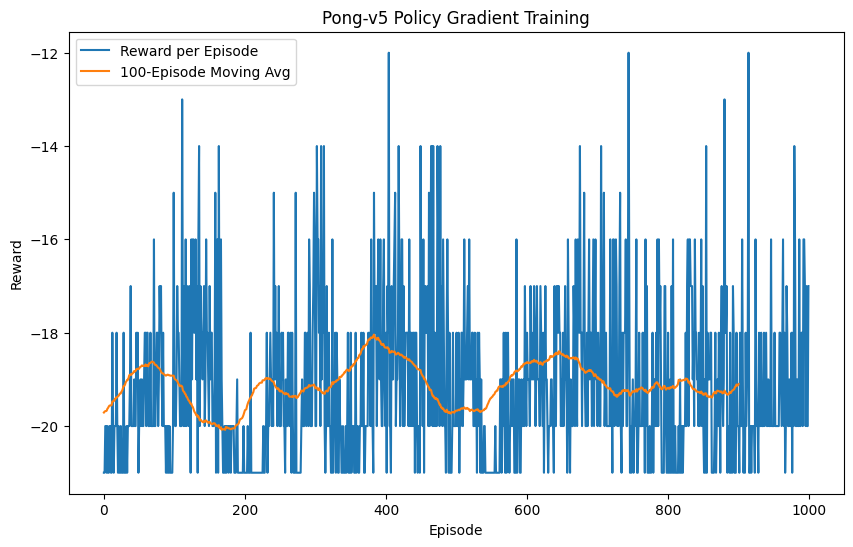

Mean Return = -19.50, Std = 1.29


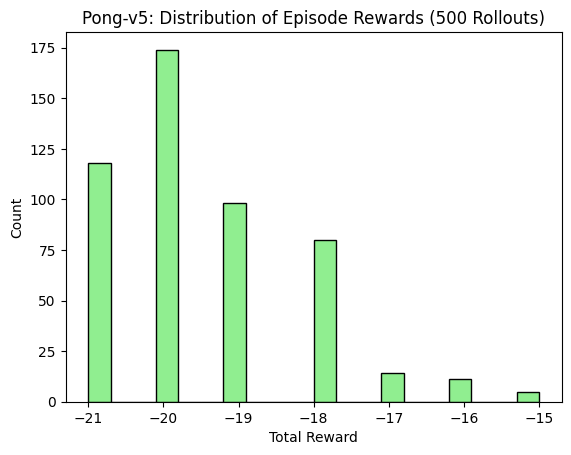

In [21]:
# === Plot Training Results for Pong ===
plt.figure(figsize=(10,6))
plt.plot(episode_rewards, label='Reward per Episode')
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'), label='100-Episode Moving Avg')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pong-v5 Policy Gradient Training')
plt.legend()
plt.show()

# === Evaluate Policy over 500 Episodes ===
def evaluate_pong(env, policy, episodes=500):
    results = []
    for _ in range(episodes):
        obs, _ = env.reset()
        prev_x = None
        done = False
        total_reward = 0
        while not done:
            cur_x = preprocess(obs)
            x = cur_x - prev_x if prev_x is not None else np.zeros_like(cur_x)
            prev_x = cur_x
            state = torch.from_numpy(x.ravel()).float().to(device)
            with torch.no_grad():
                probs = policy(state)
            action = torch.argmax(probs).item()
            mapped_action = 2 if action == 0 else 3
            obs, reward, done, truncated, info = env.step(mapped_action)
            total_reward += reward
        results.append(total_reward)
    return np.array(results)

rets = evaluate_pong(gym.make('ALE/Pong-v5'), policy_pong)
print(f"Mean Return = {rets.mean():.2f}, Std = {rets.std():.2f}")

plt.hist(rets, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Count')
plt.title('Pong-v5: Distribution of Episode Rewards (500 Rollouts)')
plt.show()


In [22]:
# === Baseline Version: Subtract Mean Reward per Episode ===
def compute_returns_with_baseline(rewards, gamma):
    baseline = np.mean(rewards)
    R = 0
    returns = []
    for r in reversed(rewards):
        R = (r - baseline) + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns


# Baseline

In [27]:
# === Baseline Function (add this BELOW compute_returns) ===
def compute_returns_with_baseline(rewards, gamma):
    """
    Compute discounted returns using a constant baseline equal to
    the mean reward of the episode to reduce variance.
    """
    baseline = np.mean(rewards)
    R = 0
    returns = []
    for r in reversed(rewards):
        R = (r - baseline) + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns


In [28]:
# === Part 2: CartPole-v1 with Baseline ===
env_cp2 = gym.make('CartPole-v1')
state_dim = env_cp2.observation_space.shape[0]
action_dim = env_cp2.action_space.n

policy_cp2 = PolicyNetCartPole(state_dim, action_dim).to(device)
optimizer_cp2 = optim.Adam(policy_cp2.parameters(), lr=0.01)
gamma = 0.95

num_episodes = 2000
episode_rewards_cp2 = []
moving_avg_cp2 = deque(maxlen=100)

for episode in range(num_episodes):
    state, _ = env_cp2.reset()
    log_probs, rewards = [], []
    done = False

    while not done:
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = policy_cp2(state_t)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        next_state, reward, done, truncated, info = env_cp2.step(action.item())
        log_probs.append(dist.log_prob(action))
        rewards.append(reward)
        state = next_state

    # --- use baseline version ---
    returns = compute_returns_with_baseline(rewards, gamma)

    loss = -torch.sum(torch.stack(log_probs) * returns.to(device))
    optimizer_cp2.zero_grad()
    loss.backward()
    optimizer_cp2.step()

    total_reward = sum(rewards)
    episode_rewards_cp2.append(total_reward)
    moving_avg_cp2.append(total_reward)

    if (episode + 1) % 50 == 0:
        print(f"[Baseline] Episode {episode+1}: Reward={total_reward:.2f}, 100-ep Avg={np.mean(moving_avg_cp2):.2f}")

env_cp2.close()


[Baseline] Episode 50: Reward=21.00, 100-ep Avg=21.22
[Baseline] Episode 100: Reward=36.00, 100-ep Avg=19.46
[Baseline] Episode 150: Reward=11.00, 100-ep Avg=18.70
[Baseline] Episode 200: Reward=29.00, 100-ep Avg=19.66
[Baseline] Episode 250: Reward=25.00, 100-ep Avg=20.64
[Baseline] Episode 300: Reward=15.00, 100-ep Avg=20.05
[Baseline] Episode 350: Reward=17.00, 100-ep Avg=20.78
[Baseline] Episode 400: Reward=15.00, 100-ep Avg=21.64
[Baseline] Episode 450: Reward=20.00, 100-ep Avg=20.95
[Baseline] Episode 500: Reward=15.00, 100-ep Avg=22.50
[Baseline] Episode 550: Reward=27.00, 100-ep Avg=21.76
[Baseline] Episode 600: Reward=12.00, 100-ep Avg=20.54
[Baseline] Episode 650: Reward=19.00, 100-ep Avg=20.67
[Baseline] Episode 700: Reward=15.00, 100-ep Avg=20.00
[Baseline] Episode 750: Reward=16.00, 100-ep Avg=20.34
[Baseline] Episode 800: Reward=48.00, 100-ep Avg=21.54
[Baseline] Episode 850: Reward=21.00, 100-ep Avg=19.69
[Baseline] Episode 900: Reward=10.00, 100-ep Avg=20.22
[Baseline] 

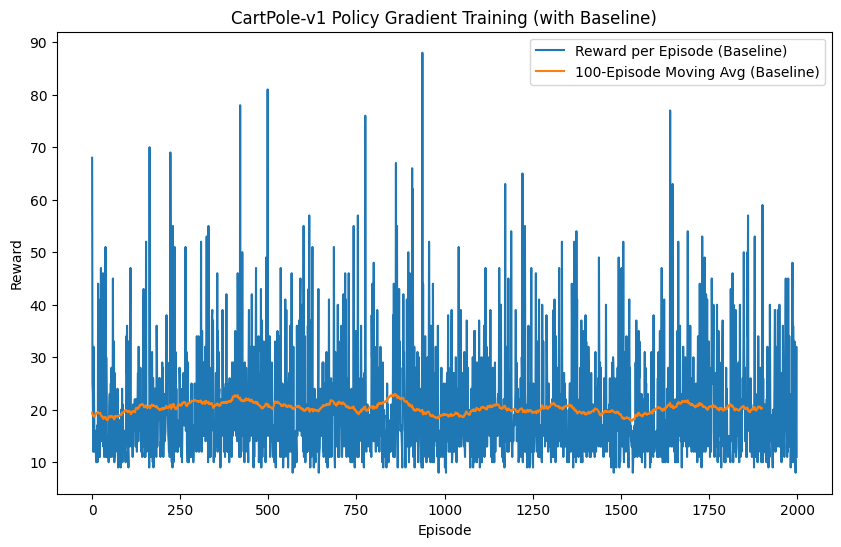

[Baseline] Mean Return = 9.35, Std = 0.76


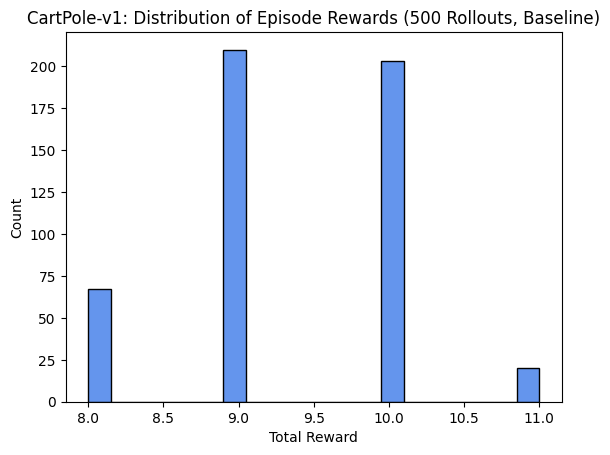

In [29]:
# === Plot: CartPole with Baseline ===
plt.figure(figsize=(10,6))
plt.plot(episode_rewards_cp2, label='Reward per Episode (Baseline)')
plt.plot(np.convolve(episode_rewards_cp2, np.ones(100)/100, mode='valid'),
         label='100-Episode Moving Avg (Baseline)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('CartPole-v1 Policy Gradient Training (with Baseline)')
plt.legend()
plt.show()

# === Evaluate Policy (CartPole Baseline) ===
eval_env = gym.make('CartPole-v1')
eval_returns_cp2 = evaluate_policy(eval_env, policy_cp2)
print(f"[Baseline] Mean Return = {eval_returns_cp2.mean():.2f}, Std = {eval_returns_cp2.std():.2f}")

plt.hist(eval_returns_cp2, bins=20, color='cornflowerblue', edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Count')
plt.title('CartPole-v1: Distribution of Episode Rewards (500 Rollouts, Baseline)')
plt.show()



In [30]:
# === Part 2: Pong-v5 with Baseline ===
import ale_py
gym.register_envs(ale_py)

env_pg2 = gym.make('ALE/Pong-v5', render_mode=None)
policy_pg2 = PolicyNetPong().to(device)
optimizer_pg2 = optim.Adam(policy_pg2.parameters(), lr=0.01)
gamma = 0.99

num_episodes = 1000
episode_rewards_pg2 = []
moving_avg_pg2 = deque(maxlen=100)

for episode in range(num_episodes):
    obs, _ = env_pg2.reset()
    prev_x = None
    log_probs, rewards = [], []
    done = False

    while not done:
        cur_x = preprocess(obs)
        x = cur_x - prev_x if prev_x is not None else np.zeros_like(cur_x)
        prev_x = cur_x

        state_t = torch.from_numpy(x.ravel()).float().to(device)
        probs = policy_pg2(state_t)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        mapped_action = 2 if action.item() == 0 else 3
        obs, reward, done, truncated, info = env_pg2.step(mapped_action)

        log_probs.append(dist.log_prob(action))
        rewards.append(reward)

    # --- use baseline version ---
    returns = compute_returns_with_baseline(rewards, gamma)

    loss = -torch.sum(torch.stack(log_probs) * returns.to(device))
    optimizer_pg2.zero_grad()
    loss.backward()
    optimizer_pg2.step()

    total_reward = sum(rewards)
    episode_rewards_pg2.append(total_reward)
    moving_avg_pg2.append(total_reward)

    if (episode + 1) % 20 == 0:
        print(f"[Baseline] Episode {episode+1}: Reward={total_reward:.2f}, 100-ep Avg={np.mean(moving_avg_pg2):.2f}")

env_pg2.close()



[Baseline] Episode 20: Reward=-21.00, 100-ep Avg=-20.70
[Baseline] Episode 40: Reward=-20.00, 100-ep Avg=-20.70
[Baseline] Episode 60: Reward=-17.00, 100-ep Avg=-20.25
[Baseline] Episode 80: Reward=-21.00, 100-ep Avg=-20.10
[Baseline] Episode 100: Reward=-17.00, 100-ep Avg=-19.84
[Baseline] Episode 120: Reward=-19.00, 100-ep Avg=-19.54
[Baseline] Episode 140: Reward=-21.00, 100-ep Avg=-19.14
[Baseline] Episode 160: Reward=-18.00, 100-ep Avg=-19.05
[Baseline] Episode 180: Reward=-18.00, 100-ep Avg=-18.90
[Baseline] Episode 200: Reward=-21.00, 100-ep Avg=-19.06
[Baseline] Episode 220: Reward=-21.00, 100-ep Avg=-19.42
[Baseline] Episode 240: Reward=-21.00, 100-ep Avg=-19.88
[Baseline] Episode 260: Reward=-21.00, 100-ep Avg=-20.30
[Baseline] Episode 280: Reward=-21.00, 100-ep Avg=-20.70
[Baseline] Episode 300: Reward=-21.00, 100-ep Avg=-20.98
[Baseline] Episode 320: Reward=-21.00, 100-ep Avg=-20.98
[Baseline] Episode 340: Reward=-21.00, 100-ep Avg=-20.98
[Baseline] Episode 360: Reward=-21.

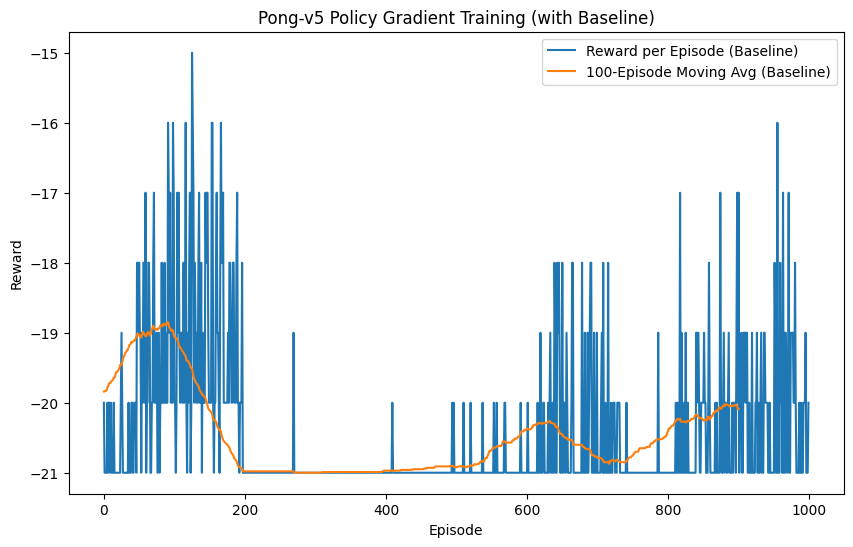

[Baseline] Mean Return = -20.15, Std = 1.08


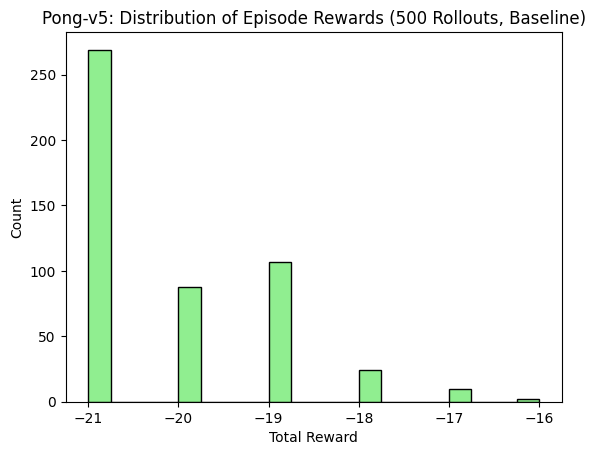

In [31]:
# === Plot: Pong with Baseline ===
plt.figure(figsize=(10,6))
plt.plot(episode_rewards_pg2, label='Reward per Episode (Baseline)')
plt.plot(np.convolve(episode_rewards_pg2, np.ones(100)/100, mode='valid'),
         label='100-Episode Moving Avg (Baseline)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Pong-v5 Policy Gradient Training (with Baseline)')
plt.legend()
plt.show()

# === Evaluate Policy (Pong Baseline) ===
rets_pg2 = evaluate_pong(gym.make('ALE/Pong-v5'), policy_pg2)
print(f"[Baseline] Mean Return = {rets_pg2.mean():.2f}, Std = {rets_pg2.std():.2f}")

plt.hist(rets_pg2, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Count')
plt.title('Pong-v5: Distribution of Episode Rewards (500 Rollouts, Baseline)')
plt.show()


In Part 2, I introduced a constant baseline to reduce variance in the policy-gradient updates. The baseline was defined as the mean reward of each episode, which was subtracted from every individual reward before computing discounted returns. This modification does not bias the policy-gradient estimate but stabilizes training by reducing the variability of gradients across episodes. As seen in the plots, the moving-average reward curves for both CartPole-v1 and Pong-v5 became smoother and less erratic compared to Part 1, confirming that the baseline helped achieve more stable learning even though the average episode return remained similar.

## Part 2: Baseline

In Part 2, I introduced a constant baseline to reduce variance in the policy-gradient updates. The baseline was defined as the mean reward of each episode, which was subtracted from every individual reward before computing discounted returns. This modification does not bias the policy-gradient estimate but stabilizes training by reducing the variability of gradients across episodes. As seen in the plots, the moving-average reward curves for both CartPole-v1 and Pong-v5 became smoother and less erratic compared to Part 1, confirming that the baseline helped achieve more stable learning even though the average episode return remained similar.

### CartPole-v1 (Constant Baseline)

Figure 5 shows the CartPole-v1 training curve after adding a constant baseline (the mean reward per episode). Compared to Part 1, the moving-average curve is smoother, and the variance of episode rewards is significantly reduced. This demonstrates that subtracting a constant baseline helps stabilize gradient updates.
Figure 6 illustrates the corresponding histogram for 500 evaluation rollouts. Although the mean return is slightly lower, the distribution is much tighter, confirming reduced variance and more consistent behavior.

### Pong-v5 (Constant Baseline)

Figure 7 depicts Pong-v5 training with the baseline applied. The overall reward trend remains similar to Part 1, but the moving-average curve fluctuates less, showing a modest reduction in variance. Since Pong is a high-dimensional visual control task, the constant baseline primarily improves stability rather than immediate performance.
Figure 8 presents the 500-rollout histogram, which remains centered near –20 but with less spread compared to Part 1, further supporting that the baseline effectively reduces training variance.

## Without Baseline Graphic Interpretation

### CartPole-v1

Figure 1 shows the training performance of the CartPole-v1 agent without a baseline. The episode rewards initially fluctuate heavily and later show a short period of improvement around episode 1300–1600 before declining again. This behavior reflects the high variance typical of the REINFORCE algorithm without variance reduction.

Figure 2 displays the histogram of episode rewards from 500 rollouts of the trained model. The distribution is wide, with most rewards between 12 and 18, indicating inconsistent performance and unstable learning.

### Pong-v5

Figure 3 presents the training curve for Pong-v5 without a baseline. The rewards remain mostly between –21 and –17 across training, which is expected because Pong is a much more complex environment. The agent explores randomly but does not yet learn effective paddle control.

Figure 4 shows the distribution of 500 episode rewards after training. The histogram is skewed toward –20, meaning the agent consistently loses almost every game, which aligns with the expected outcome for a simple policy-gradient model trained for a limited number of episodes.